In [11]:
%env CESM_ROOT=/glade/work/francines/my_cesm_sandbox

import os, sys

cesmroot = os.environ.get('CESM_ROOT')
# s2sfcstroot = os.path.join(os.path.dirname(os.path.join(os.path.abspath(__file__))), os.path.pardir)

if cesmroot is None:
    raise SystemExit("ERROR: CESM_ROOT must be defined in environment")

_LIBDIR = os.path.join(cesmroot,"cime","scripts","Tools")
sys.path.append(_LIBDIR)
_LIBDIR = os.path.join(cesmroot,"cime","scripts","lib")
sys.path.append(_LIBDIR)

import CIME.build as build
from standard_script_setup import *
from CIME.case             import Case
from CIME.utils            import safe_copy
from argparse              import RawTextHelpFormatter
from CIME.locked_files          import lock_file, unlock_file


def build_base_case(baseroot, basecasename,res, compset, overwrite,
                    user_mods_dir, project, pecount=None):
    
    caseroot = os.path.join(baseroot,basecasename)
    print(caseroot)
    
    if overwrite and os.path.isdir(caseroot):
        shutil.rmtree(caseroot)
            
    with Case(caseroot, read_only=False) as case:
        if not os.path.isdir(caseroot):
            
            case.create(os.path.basename(caseroot), cesmroot, compset, res,
                        run_unsupported=True, answer="r",walltime="04:00:00",
                        user_mods_dir=user_mods_dir, pecount=pecount, project=project,machine_name="cheyenne")
            
            # make sure that changing the casename will not affect these variables
            
            #xml change all of our shit

            if basecasename =="CAM5_32levs": 
                case.set_value("CAM_CONFIG_OPTS","-phys cam5 -nlev 32")
            
            case.set_value("DOUT_S",False)
            case.set_value("STOP_OPTION","nhours")
            case.set_value("STOP_N", 6)
            case.set_value("JOB_QUEUE", "premium")
            case.set_value("ROF_NCPL", 48)
            case.set_value("GLC_NCPL", 48)
            
            #user_namelist_cam:
            #case.set_value("CLM_NAMELIST_OPTS", "use_init_interp=.true.")

        rundir = case.get_value("RUNDIR")
        per_run_case_updates(case, date, sdrestdir, user_mods_dir, rundir)
        build.case_build(caseroot, case=case, save_build_provenance=False)

        return caseroot

def update_namelist(baseroot,basecasename,psuedo_obs_dir):
        
    caseroot = os.path.join(baseroot,basecasename)
    fn_nl = caseroot+'/user_nl_cam'
    
    lines =[" "
        "nhtfrq = 0, -6, 1"
        "mfilt = 1, 1"
        "ndens = 2, 2"
        "fincl2 = 'U:A','V:A', 'Q:A', 'T:A', 'PS:A', 'Nudge_U', 'Nudge_V', 'Nudge_T', 'Target_U', 'Target_V', 'Target_T'"
        "&nudging_nl"
         " Nudge_Model        =.true."
         " Nudge_Path         ='"+psuedo_obs_dir"'"
         " Nudge_File_Template='/test_pseudoobs_UVT.h1.%y-%m-%d-%s.nc'"
         " Nudge_Beg_Year =1979"
         " Nudge_Beg_Month=1"
         " Nudge_Beg_Day=1"
         " Nudge_End_Year =2019"
         " Nudge_End_Month=8"
         " Nudge_End_Day  =31"
         " Nudge_Uprof =2"
         " Nudge_Vprof =2"
         " Nudge_Tprof =2"
         " Nudge_Qprof =0"
         " Nudge_PSprof =0"
         " Nudge_Ucoef =1.0"
         " Nudge_Vcoef =1.0"
         " Nudge_Tcoef =1.0"
         " Nudge_Qcoef =0.0"
         " Nudge_Force_Opt = 1"
         " Nudge_Times_Per_Day = 4"
         " Model_Times_Per_Day = 48"
         " Nudge_TimeScale_Opt = 0"
         " Nudge_Vwin_Lindex = 6."
         " Nudge_Vwin_Ldelta = 0.001"
         " Nudge_Vwin_Hindex = 33."
         " Nudge_Vwin_Hdelta = 0.001"
         " Nudge_Vwin_Invert = .false."
         " Nudge_Hwin_lat0     = 0."
         " Nudge_Hwin_latWidth = 999."
         " Nudge_Hwin_latDelta = 1.0"
         " Nudge_Hwin_lon0     = 180."
         " Nudge_Hwin_lonWidth = 999."
         " Nudge_Hwin_lonDelta = 1.0"
         " Nudge_Hwin_Invert   = .false."
        ]
        
def _main_func(description):
    
    psuedo_obs_dir = '/glade/work/wchapman/pseudoobs_V2'
    
    #one
    #/glade/work/francines/my_cesm_sandbox/cime/scripts/create_newcase  --case $CAM5DIR --run-unsupported --compset HIST_CAM50_CLM50%SP_CICE%PRES_DOCN%DOM_MOSART_SGLC_SWAV  --res f09_g16 --mach cheyenne --project $PROJ
    baseroot="/glade/u/home/wchapman/CAM5_CAM6_SuperModel/"
    basecasename="/CAM5_32levs_V2"
    res = "f09_g16"
    compset= "HIST_CAM50_CLM50%SP_CICE%PRES_DOCN%DOM_MOSART_SGLC_SWAV"
    user_mods_dir="/glade/u/wchapman/CAM5_CAM6_SuperModel/Source_Mods_Files"
    overwrite = True
    
    caseroot = build_base_case(baseroot, basecasename, res,
                            compset, overwrite, user_mods_dir,project="P54048000")
    
    update_namelist(baseroot,basecasename)
    
    #two
    # caseroot = build_base_case(baseroot, basecasename, basemonth, res,
    #                         compset, overwrite, sdrestdir, user_mods_dir,project="P54048000")
    # update_namelist(baseroot,basecasename)
    
    
if __name__ == "__main__":
    _main_func(__doc__)

In [39]:
baseroot="/glade/u/home/wchapman/CAM5_CAM6_SuperModel"
basecasename="CAM5_32levs_V2/"
os.path.join(baseroot,basecasename)

'/glade/u/home/wchapman/CAM5_CAM6_SuperModel/CAM5_32levs_V2/'

In [10]:
psuedo_obs_dir = '/glade/work/wchapman/pseudoobs_V2'

lines =["! Users should add all user specific namelist changes below in the form of",
        "! namelist_var = new_namelist_value",
        " ",
        "nhtfrq = 0, -6",
        "mfilt = 1, 1",
        "ndens = 2, 2",
        "fincl2 = 'U:A','V:A', 'Q:A', 'T:A', 'PS:A', 'Nudge_U', 'Nudge_V', 'Nudge_T', 'Target_U', 'Target_V', 'Target_T'",
        "&nudging_nl",
         " Nudge_Model        =.true.",
         " Nudge_Path         ='"+psuedo_obs_dir+"'",
         " Nudge_File_Template='/test_pseudoobs_UVT.h1.%y-%m-%d-%s.nc'",
         " Nudge_Beg_Year =1979",
         " Nudge_Beg_Month=1",
         " Nudge_Beg_Day=1",
         " Nudge_End_Year =2019",
         " Nudge_End_Month=8",
         " Nudge_End_Day  =31",
         " Nudge_Uprof =2",
         " Nudge_Vprof =2",
         " Nudge_Tprof =2",
         " Nudge_Qprof =0",
         " Nudge_PSprof =0",
         " Nudge_Ucoef =1.0",
         " Nudge_Vcoef =1.0",
         " Nudge_Tcoef =1.0",
         " Nudge_Qcoef =0.0",
         " Nudge_Force_Opt = 1",
         " Nudge_Times_Per_Day = 4",
         " Model_Times_Per_Day = 48",
         " Nudge_TimeScale_Opt = 0",
         " Nudge_Vwin_Lindex = 6.",
         " Nudge_Vwin_Ldelta = 0.001",
         " Nudge_Vwin_Hindex = 33.",
         " Nudge_Vwin_Hdelta = 0.001",
         " Nudge_Vwin_Invert = .false.",
         " Nudge_Hwin_lat0     = 0.",
         " Nudge_Hwin_latWidth = 999.",
         " Nudge_Hwin_latDelta = 1.0",
         " Nudge_Hwin_lon0     = 180.",
         " Nudge_Hwin_lonWidth = 999.",
         " Nudge_Hwin_lonDelta = 1.0",
         " Nudge_Hwin_Invert   = .false.",
        ]
filename = "./example.txt"

with open(filename, "a") as file:
    for line in lines:
        file.write(line + "\n")

In [23]:
import glob
import os
import pandas as pd
import datetime

In [19]:
list_of_files = glob.glob('/glade/work/wchapman/pseudoobs_V2/*.nc') # get the latest file in the pseudo obs ...
latest_file = max(list_of_files, key=os.path.getctime)
list_of_files

['/glade/work/wchapman/pseudoobs_V2/CAM5_32levs.cam.h1.1979-01-02-21600.nc',
 '/glade/work/wchapman/pseudoobs_V2/CAM6_f09_g16.cam.h1.1979-01-01-43200.nc',
 '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-02-43200.nc',
 '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-01-43200.nc',
 '/glade/work/wchapman/pseudoobs_V2/CAM6_f09_g16.cam.h1.1979-01-02-00000.nc',
 '/glade/work/wchapman/pseudoobs_V2/CAM6_f09_g16.cam.h1.1979-01-02-21600.nc',
 '/glade/work/wchapman/pseudoobs_V2/CAM5_32levs.cam.h1.1979-01-01-43200.nc',
 '/glade/work/wchapman/pseudoobs_V2/CAM6_f09_g16.cam.h1.1979-01-01-64800.nc',
 '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-02-00000.nc',
 '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-02-21600.nc',
 '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-.nc',
 '/glade/work/wchapman/pseudoobs_V2/CAM5_32levs.cam.h1.1979-01-02-00000.nc',
 '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-01

In [42]:
def inc_hours(current_time,inc_amount):
    
    increment_time = str(pd.to_datetime(current_time[0:-6]+' '+str(datetime.timedelta(seconds=float(current_time[-5:]))))+datetime.timedelta(hours=inc_amount))
    
    # Extract the time component from the incremented timestamp
    ts = str(increment_time)[-8:]

    # Convert the time component from HH:MM:SS to seconds
    secs = sum(int(x) * 60 ** i for i, x in enumerate(reversed(ts.split(':')))) #change seconds to HH:MM:SS 

    inc_time_string = str(increment_time)[:10]+'-'+f'{secs:05}'
    return inc_time_string 



In [43]:
inc_hours('1979-01-01-64800',6)

'1979-01-02-00000'

In [45]:
dd = '/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-01-21600.nc'

dd.split('.')[-2]

'1979-01-01-21600'

In [1]:
import xarray as xr

In [42]:
def average_two_files(ps_fp,file1,file2):
    
    DS_f1 = xr.open_dataset(file1)
    DS_f2 = xr.open_dataset(file2)
    
    DS_template = xr.open_dataset(ps_fp+'/Template_Nudging_File.nc',decode_times=False)
    
    DS_template['U'][:] =  ((DS_f1['U'] + DS_f2['U'])/2).values.squeeze()
    DS_template['V'][:] =  ((DS_f1['V'] + DS_f2['V'])/2).values.squeeze()
    
    
    DS_template['T'][:] =  ((DS_f1['T'] + DS_f2['T'])/2).values
    DS_template['Q'][:] =  ((DS_f1['Q'] + DS_f2['Q'])/2).values
    DS_template['PS'][:] =  ((DS_f1['PS'] + DS_f2['PS'])/2).values
 
    # fout = ps_fp+'test_pseudoobs_UVT.h1.'+inc_str+'.nc'
    # DS_template.to_netcdf(fout,format="NETCDF3_CLASSIC")
   
    return DS_template

In [44]:
ps_fp = '/glade/work/wchapman/pseudoobs_V2/'

f1 = '/glade/scratch/wchapman/CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-02-21600.nc'
f2 = '/glade/scratch/wchapman/CAM6_f09_g16_V2/run/CAM6_f09_g16_V2.cam.h1.1979-01-02-21600.nc'

bb = average_two_files(ps_fp,f1,f2)

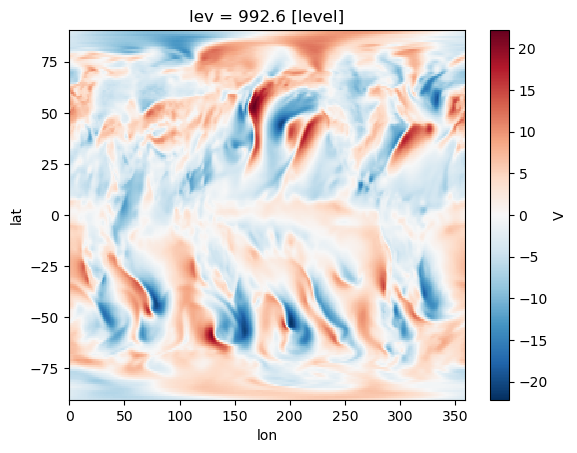

In [61]:
bb['V'].sel(lev=1000,method='nearest').plot()

In [41]:
DS_template = xr.open_dataset(ps_fp+'/Template_Nudging_File.nc',decode_times=False)
DS_template['T']

<xarray.DataArray 'T' (time: 1, lev: 32, lat: 192, lon: 288)>
[1769472 values with dtype=float32]
Coordinates:
  * time     (time) float64 179.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:          Temperature
    units:              K
    source_file:        /glade/collections/rda/data/ds627.0/ei.oper.an.ml/201...
    source_field_name:  T_GDS4_HYBL
    horz_interp_flag:   binning
    vert_interp_flag:   quad_logp_opt1

In [25]:
avy1 = xr.open_dataset('/glade/scratch/wchapman/CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-02-21600.nc')
avy2 = xr.open_dataset('/glade/scratch/wchapman/CAM6_f09_g16_V2/run/CAM6_f09_g16_V2.cam.h1.1979-01-02-21600.nc')

# avy2 = xr.open_dataset('/glade/scratch/wchapman/CAM/test_pseudoobs_UVT.h1.1979-01-01-21600.nc')

In [33]:
ds['U'][:,:]=((avy1['U'] + avy2['U'])/2).values

In [34]:
ds['U']

<xarray.DataArray 'U' (time: 1, lev: 32, lat: 192, lon: 288)>
array([[[[ -5.3797665,  -5.419696 ,  -5.457046 , ...,  -5.2446966,
           -5.292246 ,  -5.3372765],
         [ -5.960438 ,  -6.0035434,  -6.043988 , ...,  -5.815392 ,
           -5.866336 ,  -5.914694 ],
         [ -6.558104 ,  -6.6057053,  -6.6503563, ...,  -6.3979125,
           -6.454172 ,  -6.507582 ],
         ...,
         [-13.592995 , -13.778986 , -13.961374 , ..., -13.01362  ,
          -13.210271 , -13.403411 ],
         [-13.61939  , -13.817574 , -14.010666 , ..., -12.995119 ,
          -13.208065 , -13.41619  ],
         [-13.347698 , -13.545161 , -13.7361765, ..., -12.717586 ,
          -12.933812 , -13.143883 ]],

        [[ -3.7514455,  -3.783064 ,  -3.812882 , ...,  -3.6459417,
           -3.682868 ,  -3.7180414],
         [ -4.0493317,  -4.0843897,  -4.1177597, ...,  -3.9341922,
           -3.974215 ,  -4.0126014],
         [ -4.480362 ,  -4.523292 ,  -4.564539 , ...,  -4.341941 ,
           -4.389638 ,  -4.4357953],
...
         [  6.5225124,   6.451377 ,   6.378761 , ...,   6.7276993,
            6.66044  ,   6.592103 ],
         [  8.494408 ,   8.363821 ,   8.2302   , ...,   8.86744  ,
            8.746258 ,   8.621901 ],
         [ 10.614283 ,  10.447958 ,  10.27666  , ...,  11.082633 ,
           10.931696 ,  10.775555 ]],

        [[ -4.34229  ,  -4.2655945,  -4.1868687, ...,  -4.5598354,
           -4.4894457,  -4.4169188],
         [ -6.119239 ,  -6.0355573,  -5.947588 , ...,  -6.343197 ,
           -6.2730427,  -6.1984086],
         [ -6.7611084,  -6.700597 ,  -6.634558 , ...,  -6.902149 ,
           -6.8599195,  -6.8143177],
         ...,
         [  6.36742  ,   6.3101234,   6.249501 , ...,   6.5176806,
            6.470603 ,   6.4205856],
         [  7.6903505,   7.6306715,   7.5678253, ...,   7.8495193,
            7.799958 ,   7.746827 ],
         [  9.350458 ,   9.301384 ,   9.247871 , ...,   9.470722 ,
            9.43516  ,   9.39506  ]]]], dtype=float32)
Coordinates:
  * time     (time) float64 179.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [5]:
ds = xr.open_dataset('/glade/work/wchapman/pseudoobs_V2/Template_Nudging_File.nc',decode_times=False)

In [89]:
ls -lathr /glade/work/wchapman/pseudoobs_V2/

total 2.1G
drwxr-xr-x 82 wchapman ncar  32K May 12 04:07 ../
-rw-r--r--  1 wchapman ncar  739 May 12 07:27 Add_fake_Time_File.py
drwxr-xr-x  2 wchapman ncar 4.0K May 12 07:42 .ipynb_checkpoints/
-rwxr-xr-x  1 wchapman ncar  600 May 12 07:44 average_restart_supercam5cam6.sh*
-rw-r--r--  1 wchapman ncar  68M May 12 08:08 CAM6_f09_g16.cam.h1.1979-01-01-43200.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:08 CAM5_32levs.cam.h1.1979-01-01-43200.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:10 CAM6_f09_g16.cam.h1.1979-01-01-64800.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:10 CAM5_32levs.cam.h1.1979-01-01-64800.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:13 CAM6_f09_g16.cam.h1.1979-01-02-00000.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:13 CAM5_32levs.cam.h1.1979-01-02-00000.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:16 CAM6_f09_g16.cam.h1.1979-01-02-21600.nc
-rw-r--r--  1 wchapman ncar  68M May 12 08:16 CAM5_32levs.cam.h1.1979-01-02-21600.nc
-rw-r--r--  1 wchapman ncar  28M May 15 0

In [91]:
ds2 = xr.open_dataset('/glade/work/wchapman/pseudoobs_V2/test_pseudoobs_UVT.h1.1979-01-21-21600.nc',decode_times=False)

In [92]:
ds2

<xarray.Dataset>
Dimensions:  (time: 1, scalar: 1, lev: 32, ilev: 33, lat: 192, lon: 288,
              slat: 191, slon: 288)
Coordinates:
  * time     (time) float64 179.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * slat     (slat) float64 -89.53 -88.59 -87.64 -86.7 ... 87.64 88.59 89.53
  * slon     (slon) float64 -0.625 0.625 1.875 3.125 ... 354.4 355.6 356.9 358.1
Dimensions without coordinates: scalar
Data variables: (12/26)
    ndbase   (scalar) int32 ...
    nsbase   (scalar) int32 ...
    nbdate   (scalar) int32 ...
    nbsec    (scalar) int32 ...
    ndcur    (time) float64 ...
    nscur    (time) int32 ...
    ...       ...
    V        (lev, lat, lon) float64 ...
    VS       (lev, lat, slon) float64 ...
    T        (time, lev, lat, lon) float32 ...
    Q        (time, lev, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    PHIS     (time, lat, lon) float32 ...
Attributes: (12/17)
    Conventions:            NCAR-CSM
    Description:            Re-gridded CAM Initial Conditions from the follow...
    source1:                /glade/collections/rda/data/ds627.0/ei.oper.an.ml...
    source2:                /glade/collections/rda/data/ds627.0/ei.oper.an.ml...
    source3:                /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_...
    source_lev_info:        /glade/p/cesmdata/cseg/inputdata/atm/cam/inic/fv/...
    ...                     ...
    Date_Written:           Mon Mar  7 20:41:23 MST 2022
    case:                   ERAI_fv09
    vort_div_to_UV:         True; U/V derived from vort/div from input file
    ps_adjust:              True; Adjust Ps per ECMWF algorithm
    q_adjust:               True; Eliminate super-saturation
    interp_log_ps:          True; Interpolate ln(Ps) rather than Ps

In [87]:
import glob
import os
import pandas as pd
import datetime
import shutil

scratch_path = '/glade/scratch/wchapman/' #replace path
psuedo_obs_dir='/glade/work/wchapman/pseudoobs_V2' #replace path
archive_dir = '/glade/scratch/wchapman/store_super_cam5_cam6' #replace path
cam5_path = scratch_path+'/CAM5_32levs_V2/run/' #replace path
cam6_path = scratch_path+'/CAM6_f09_g16_V2/run/'#replace path


cam_replace_str = '1979-01-19-00000'

def get_time(fn):
    timstr = fn.split('.')[-2]
    dt_is = pd.to_datetime(timstr[0:-6]+' '+str(datetime.timedelta(seconds=float(timstr[-5:]))))
    
    return timstr, dt_is

def remove_files_greater(path_rem,date_str):
    
    dt_twant = pd.to_datetime(date_str[0:-6]+' '+str(datetime.timedelta(seconds=float(date_str[-5:]))))
    fns = sorted(glob.glob(cam5_path+'/*.nc'))
    
    for ff in fns:
        try:
            tmstr,dt_is = get_time(ff)
            if dt_twant<dt_is:
                print('removing file cause its greater time: ',ff)
                os.remove(ff)
        except: 
            print('could not remove: ',ff)
    return dt_twant


In [85]:
get_time('/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-01-00000.nc')

('1979-01-01-00000', Timestamp('1979-01-01 00:00:00'))

In [88]:
remove_files_greater(cam5_path,cam_replace_str)

/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-19-21600.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-19-43200.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-19-64800.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-20-00000.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-20-21600.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-20-43200.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-20-64800.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-21-00000.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.r.1979-01-19-21600.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.r.1979-01-19-43200.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.r.1979-01-19-64800.nc
/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V

Timestamp('1979-01-19 00:00:00')

In [64]:
sorted(glob.glob(cam5_path+'/*.nc'))

['/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-01-00000.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-01-21600.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-01-43200.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-01-64800.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-02-00000.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-02-21600.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-02-43200.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-02-64800.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-03-00000.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-03-21600.nc',
 '/glade/scratch/wchapman//CAM5_32levs_V2/run/CAM5_32levs_V2.cam.h1.1979-01-03-43200.nc',
 '/glade/s